# Signals and systems
## Project-Phase1
### Yasaman Jafari - 810195376

------
# Introduction
### The goal of this project is to detect road lines in sample images and videos, using Python and OpenCV.
------
## Import Package
* First, we import the required packages. We also define 2 variables ROWS and COLS.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
%matplotlib inline

ROWS = 7
COLS = 3

## Read Images
* Now, we read raw images. We use plt.xticks and plt.yticks to eliminate scales. Also in order to show all images together in one figure, we use subplots.

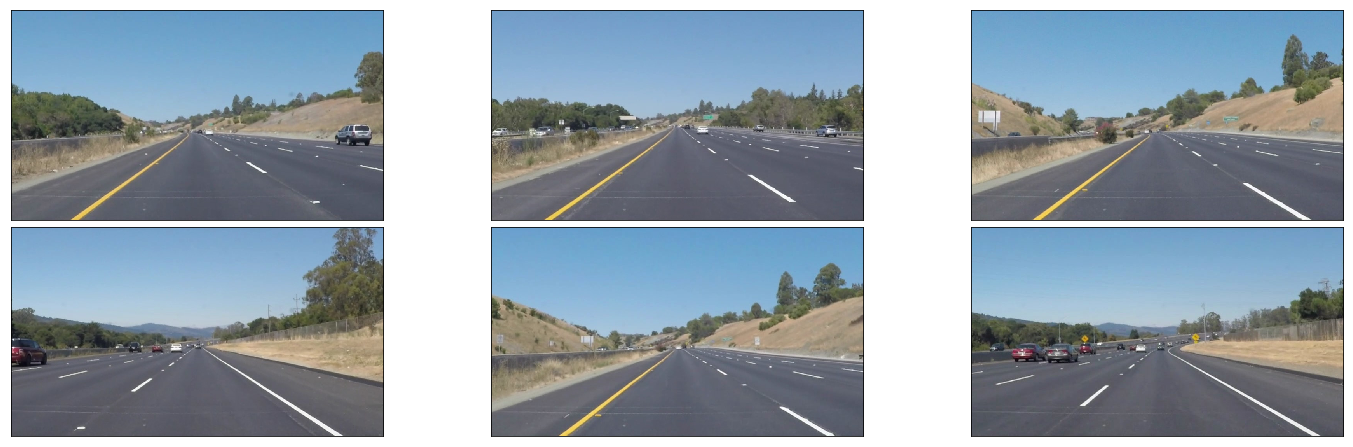

In [2]:
#reading in all images
images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

def show_images_in_subplots(images, rows, columns):
    plt.figure(figsize=(20, 21))
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0)
    plt.show()

show_images_in_subplots(images, ROWS, COLS)

## Detecting white and yellow lines
* As the road line are white and yellow, we need to use a RGB color channel to detect white and yellow lines. In other words, we need to change the color space.

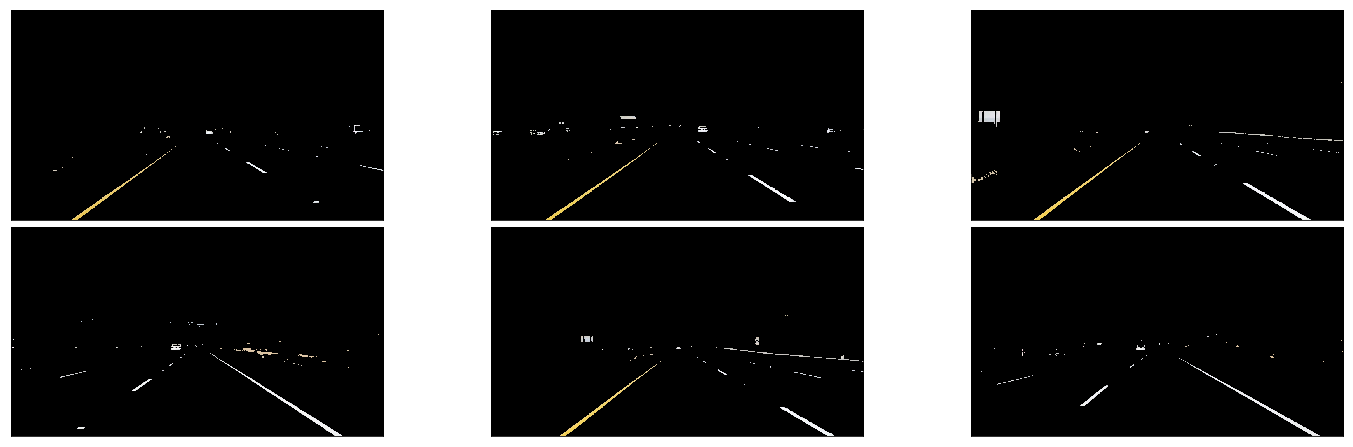

In [3]:
def detect_white_yellow(image): 
    # white lower and upper bound
    lower_white = np.uint8([200, 200, 200])
    upper_white = np.uint8([255, 255, 255])
    # yellow lower and upper bound
    lower_yellow = np.uint8([190, 190,   0])
    upper_yellow = np.uint8([255, 255, 255])
    # apply white mask
    white_mask = cv2.inRange(image, lower_white, upper_white)
    #apply yellow mask
    yellow_mask = cv2.inRange(image, lower_yellow, upper_yellow)
    #combine 2 masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    return masked_image

white_yellow_images = (list(map(detect_white_yellow, images)))
show_images_in_subplots(white_yellow_images, ROWS, COLS)

## Edge Detection
* We are going to use Canny edge detection algorithm in this part. In order to use Canny algorithm, we need to: 
    * Convert the image into GrayScale so the image will be in black and white and easier to process.
    * Apply Guassian Blur to remove noise and smooth the edges.
    
 and then we can apply Canny algorithm.

### Gray Scale
* We use OpenCV's cvtColor function to apply the GrayScale to the result of previous step.

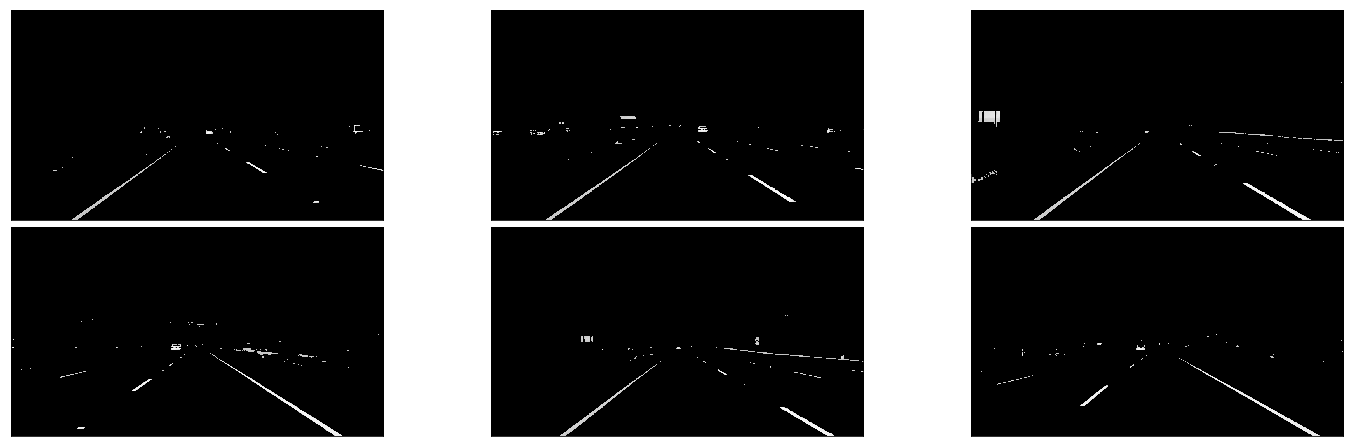

In [4]:
def apply_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_scaled_images = list(map(apply_gray_scale, white_yellow_images))

show_images_in_subplots(gray_scaled_images, ROWS, COLS)

### Guassian Blur
* Guassian Blur is used to smooth the edges. This step is required because the pixel intensity in the edges change very fast and can cause noisy edges.
* We use OpenCV's GaussianBlur function to apply the Guassian Blur to the result of previous step.
* Kernel size is considered 15 here.

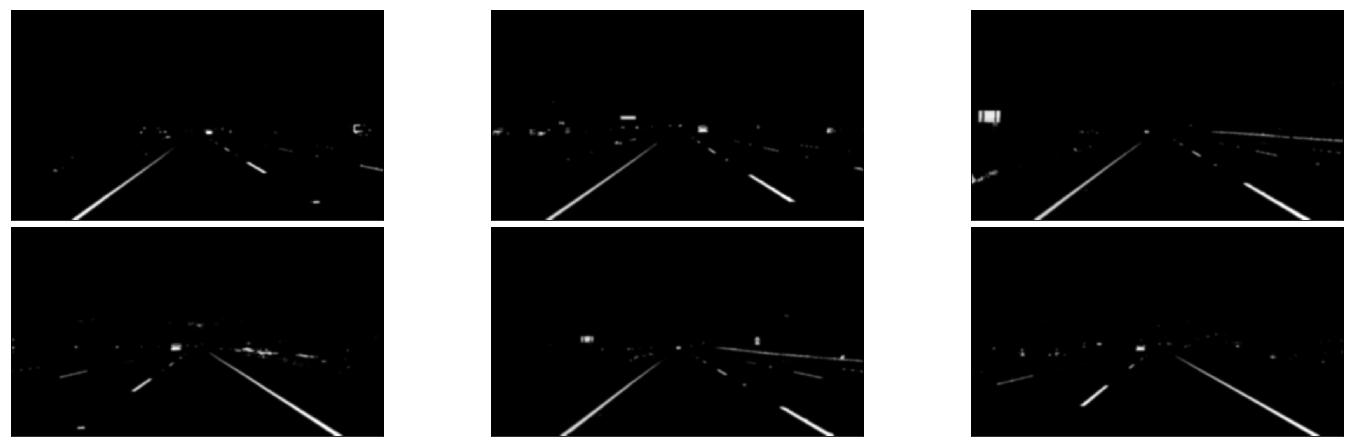

In [5]:
def apply_guassian_blur(image):
    return cv2.GaussianBlur(image, (15, 15), 0)

guassian_images = list(map(apply_guassian_blur, gray_scaled_images))

show_images_in_subplots(guassian_images, ROWS, COLS)

After applying the guassian blur, the edges turn smooth.

### Canny Edge Detector
* Finally we can apply the Canny edge detector function.
* Lower threshold is considered 50 and upper threshold is considered 150 here. When a pixel has higher gradiant than 150, it is considered an edge. If it is below the lower threshold, it is not accpted and if the gradient is between 50 and 150, it will be accpeted if it is connected to a pixel with more than 150 gradient value.

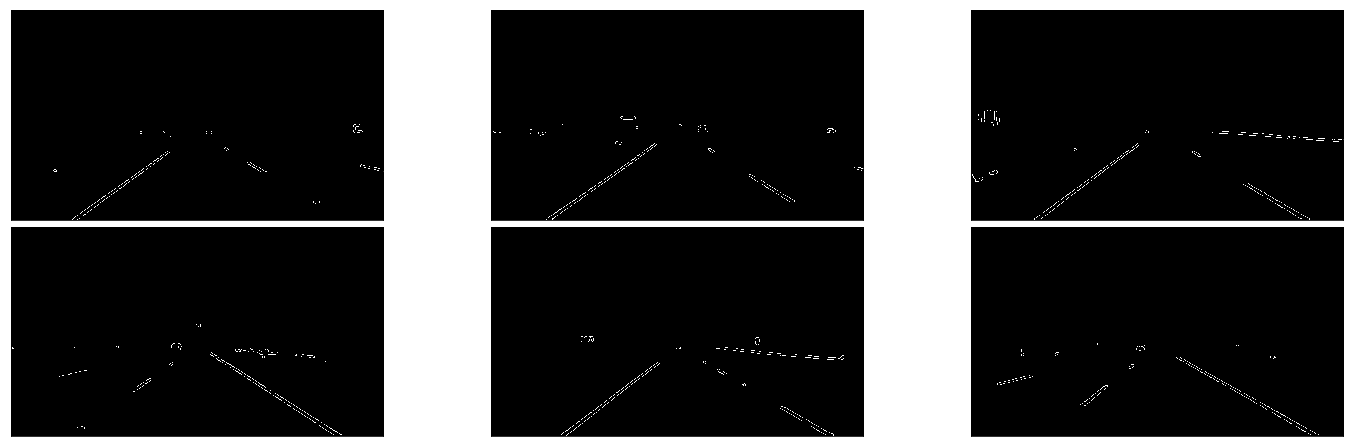

In [6]:
def detect_edges(image):
    return cv2.Canny(image, 50, 150)

canny_images = list(map(detect_edges, guassian_images))

show_images_in_subplots(canny_images, ROWS, COLS)

### Region of Interest
* We need a mask to filter unnecessary data. We are going to search in our region of interest which is going to be a triangle.

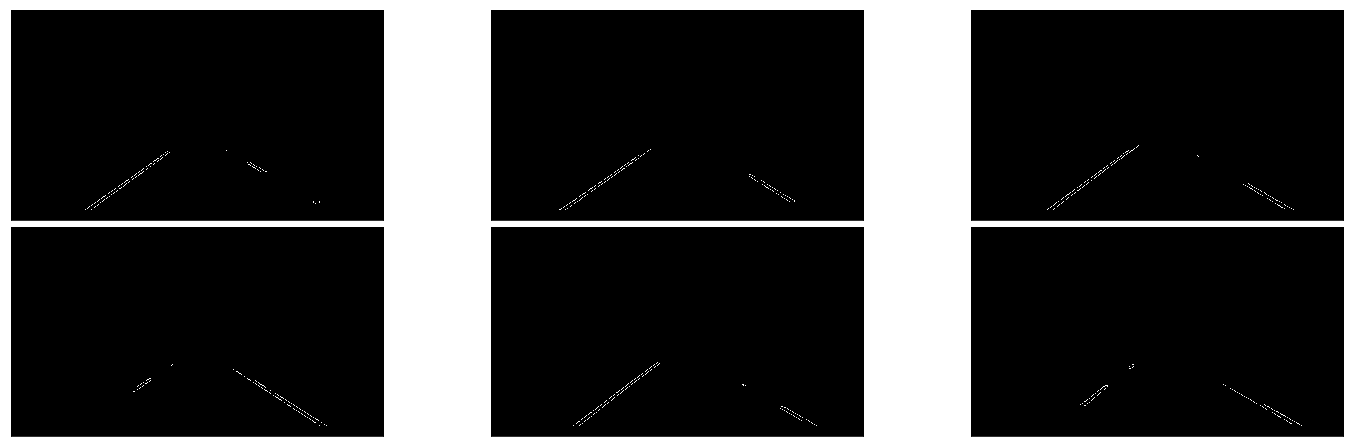

In [7]:
def select_region(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top = [cols*0.5, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, np.array([[bottom_left, top, top, bottom_right]], dtype=np.int32), (255))     
    return cv2.bitwise_and(image, mask)

masked_images = list(map(select_region, canny_images))

show_images_in_subplots(masked_images, ROWS, COLS)

### Hough Transform
* In this step, we need to find places which many lines pass through, with the help of heat map. 
    * threshold – The minimum number which decides whether a line segment is accepted or not.
    * minLineLength – Line segments which are shorter than minLineLength is not accepted.
    * maxLineGap – Gap more than maxLineGap is not accptable.

In [8]:
def detect_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=10, maxLineGap=300)

lines = list(map(detect_lines, masked_images))

### Draw Lines on Images
* Finally we draw the lines.

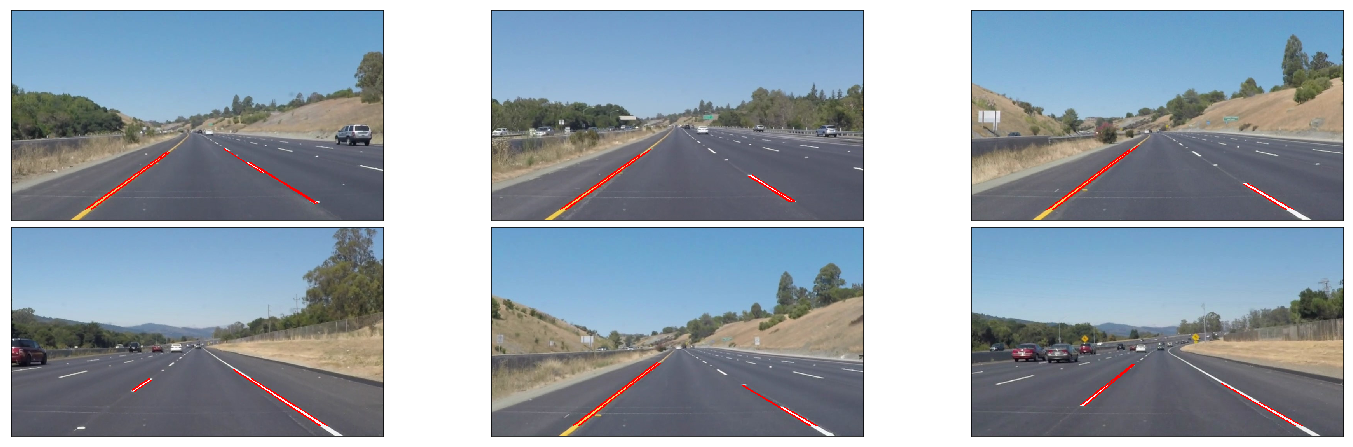

In [9]:
def draw_lines(image, lines, color=[255, 0, 0]):
    copy_image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(copy_image, (x1, y1), (x2, y2), color, 2)
    return copy_image


result = []
for image, lines in zip(images, lines):
    result.append(draw_lines(image, lines))
    
show_images_in_subplots(result, ROWS, COLS)

### Connecting Line Segments
* In previous steps, line segments are detected, now we want to connect them and draw a line.

The right line has negative slope and the left line has positive slope, so we collect all lines with positive or negative slopes on separate groups and take their average to find the desired line.

In [10]:
def average_slope_intercept(lines):
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = [] 
    right_weights = [] 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue 
            if(x2 - x1) == 0:
                throw(exep)
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: 
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
   
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane 

Now the slope and intercept should be convertedinto pixel points.

In [11]:
def make_line_points(y1, y2, line):

    if line is None:
        return None
    
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

The last step is to draw the final lines.

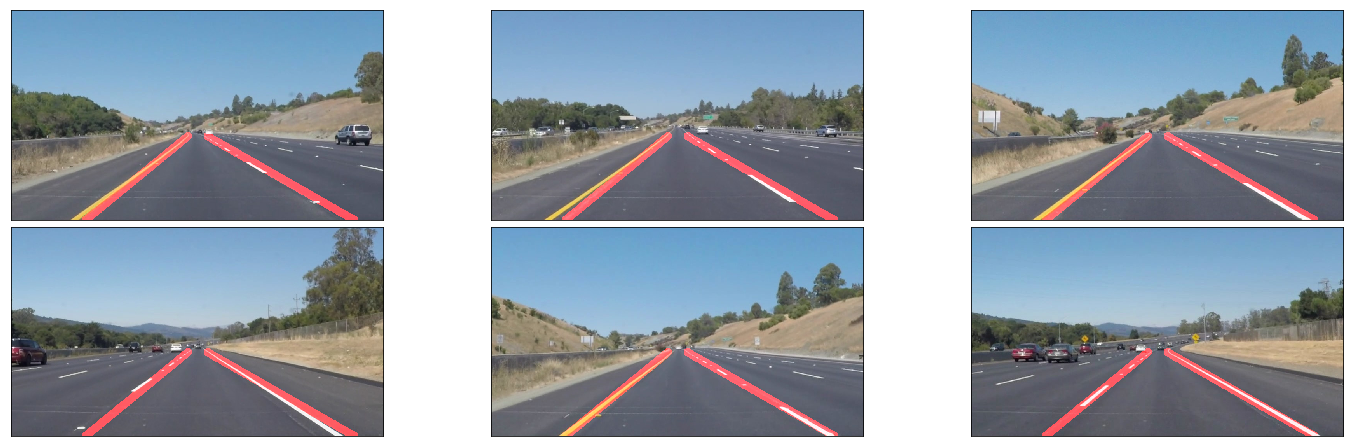

In [12]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] 
    y2 = y1*0.6     

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, line in zip(images, lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

show_images_in_subplots(lane_images, ROWS, COLS)

### Pipeline
* We use a pipeline to do all the steps in the correct order and give us the result. The try and catch section is added for the situation given in the challenge video which causes division by zero in the turning of the vehicle.

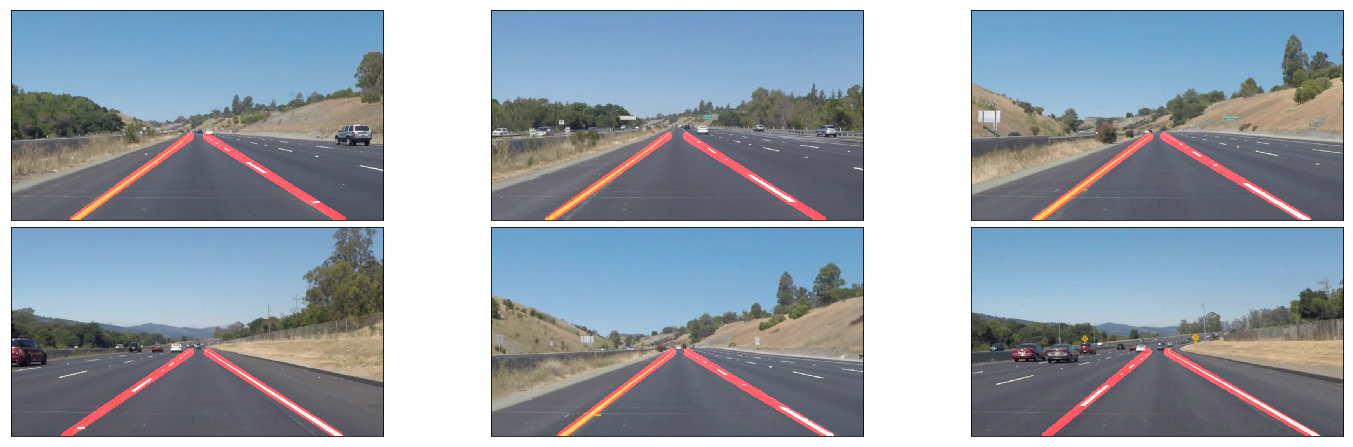

In [13]:
def detect_and_draw_lines(image):
    wy_image = detect_white_yellow(image)
    gray_image = apply_gray_scale(wy_image)
    guassian_image = apply_guassian_blur(gray_image)
    edged_image = detect_edges(guassian_image)
    triangle_image = select_region(edged_image)
    lines = detect_lines(triangle_image)
    try:
        result_img = draw_lane_lines(image, lane_lines(image, lines))
        return result_img
    except:
        return image
    
images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
result_images = []
for image, line in zip(images, lines):
    result_images.append(detect_and_draw_lines(image))
    
show_images_in_subplots(result_images, ROWS, COLS)

### Detect Lines in Video
* We load all the test videos and set the path for output videos in which they are going to be saved.

In [14]:
def process_video(video_input, video_output):
    video = VideoFileClip(os.path.join('test_videos', video_input))
    processed = video.fl_image(detect_and_draw_lines)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

Now we call the process_video function on them.

In [15]:
process_video('solidWhiteRight.mp4', 'white.mp4') 
process_video('solidYellowLeft.mp4', 'yellow.mp4')
process_video ('challenge.mp4', 'challenge.mp4')

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing video test_videos_output/yellow.mp4


100%|█████████▉| 681/682 [00:14<00:00, 50.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:10<00:00, 23.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



We use HTML to show the output videos in a table.

In [16]:
from IPython.display import HTML
HTML("""
<table>
    <tr>
        <td>
            <video width="300" height="200" controls>
             <source src="{0}">
            </video>
        </td>
        <td>
            <video width="300" height="200" controls>
             <source src="{1}">
            </video>
        </td>
        <td>
            <video width="300" height="200" controls>
             <source src="{2}">
            </video>
        </td>
    </tr>
</table>
""".format("test_videos_output/white.mp4", "test_videos_output/yellow.mp4", "test_videos_output/challenge.mp4"))

,,
